In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your CSV file into a DataFrame
file_path = 'SPY.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Normalize the data using Min-Max Scaling
def normalize_data(df):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

# Standardize the data using Standard Scaling
def standardize_data(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

# Add technical indicators
def add_technical_indicators(df):
    # Moving Averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Daily Returns
    df['Daily Returns'] = df['Close'].pct_change()

    # Volatility (20-day rolling standard deviation of daily returns)
    df['Volatility'] = df['Daily Returns'].rolling(window=20).std()

    return df

# Apply preprocessing steps
# Normalize or standardize as required (comment out the one you don't need)
# normalized_data = normalize_data(data)
# standardized_data = standardize_data(data)

# Add technical indicators
data_with_indicators = add_technical_indicators(data)

# Display the first few rows of the data with indicators
data_with_indicators.head()


,Date,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,Daily Returns,Volatility
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.941393,1003200,NaN,NaN,NaN,NaN
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.118776,480500,NaN,NaN,0.007112,NaN
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.172007,201300,NaN,NaN,0.002119,NaN
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.438093,529400,NaN,NaN,0.010571,NaN
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.544527,531500,NaN,NaN,0.004184,NaN


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load your CSV file into a DataFrame
file_path = 'SPY.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Preprocess the data
# Example: Convert 'Date' to a numeric format or remove it
data['Date'] = pd.to_datetime(data['Date']).map(pd.Timestamp.timestamp)

# Feature engineering and selection
# ...

# Split data into features and target
features = data.drop(['Close'], axis=1)
target = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize data for LSTM and RandomForest
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to create a dataset for LSTM
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Prepare data for LSTM
time_steps = 10  # Adjust the time steps
X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_scaled, y_train.values, time_steps)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test_scaled, y_test.values, time_steps)

# Ensure data is in float32 format
X_train_lstm = X_train_lstm.astype('float32')
y_train_lstm = y_train_lstm.astype('float32')

# Train Improved LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

# Train Tuned Random Forest Model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make Predictions
lstm_predictions = lstm_model.predict(X_test_lstm)
rf_predictions = rf_model.predict(X_test_scaled).reshape(-1,1)

# Align predictions for ensemble
min_length = min(len(lstm_predictions), len(rf_predictions))
ensemble_predictions = (lstm_predictions[:min_length] + rf_predictions[:min_length]) / 2

# Evaluate Ensemble Model
ensemble_error = mean_squared_error(y_test_lstm[:min_length], ensemble_predictions)
print("Ensemble Mean Squared Error:", ensemble_error)


Epoch 1/20
194/194 [==============================] - 5s 11ms/step - loss: 16521.9727
Epoch 2/20
194/194 [==============================] - 2s 10ms/step - loss: 11682.1396
Epoch 3/20
194/194 [==============================] - 2s 12ms/step - loss: 11665.7051
Epoch 4/20
194/194 [==============================] - 2s 11ms/step - loss: 11544.0840
Epoch 5/20
194/194 [==============================] - 2s 11ms/step - loss: 11601.8174
Epoch 6/20
194/194 [==============================] - 2s 11ms/step - loss: 11663.1328
Epoch 7/20
194/194 [==============================] - 2s 12ms/step - loss: 11625.9014
Epoch 8/20
194/194 [==============================] - 2s 11ms/step - loss: 11559.6201
Epoch 9/20
194/194 [==============================] - 2s 11ms/step - loss: 11429.6680
Epoch 10/20
194/194 [==============================] - 2s 11ms/step - loss: 11575.7441
Epoch 11/20
194/194 [==============================] - 2s 12ms/step - loss: 11580.6348
Epoch 12/20
194/194 [==============================]

Epoch 1/20
270/270 [==============================] - 13s 37ms/step - loss: 0.4323 - val_loss: 0.4177
Epoch 2/20
270/270 [==============================] - 9s 33ms/step - loss: 0.4197 - val_loss: 0.4215
Epoch 3/20
270/270 [==============================] - 9s 33ms/step - loss: 0.4187 - val_loss: 0.4168
Epoch 4/20
270/270 [==============================] - 9s 32ms/step - loss: 0.4176 - val_loss: 0.4162
Epoch 5/20
270/270 [==============================] - 8s 31ms/step - loss: 0.4168 - val_loss: 0.4159
Epoch 6/20
270/270 [==============================] - 8s 31ms/step - loss: 0.4167 - val_loss: 0.4153
Epoch 7/20
270/270 [==============================] - 9s 32ms/step - loss: 0.4162 - val_loss: 0.4149
Epoch 8/20
270/270 [==============================] - 8s 31ms/step - loss: 0.4161 - val_loss: 0.4162
Epoch 9/20
270/270 [==============================] - 8s 30ms/step - loss: 0.4175 - val_loss: 0.4164
Epoch 10/20
270/270 [==============================] - 8s 30ms/step - loss: 0.4157 - val_l

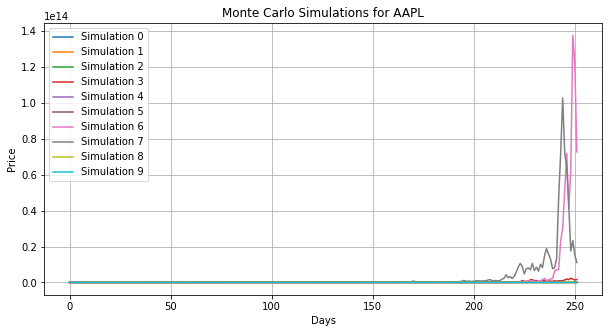

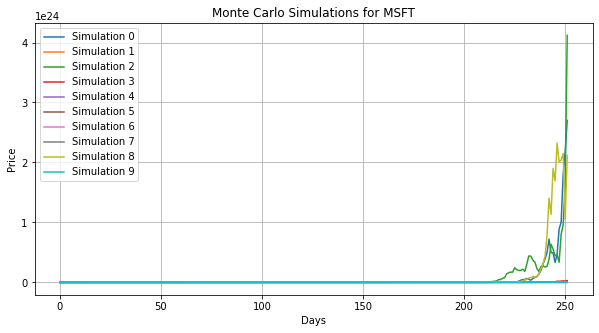

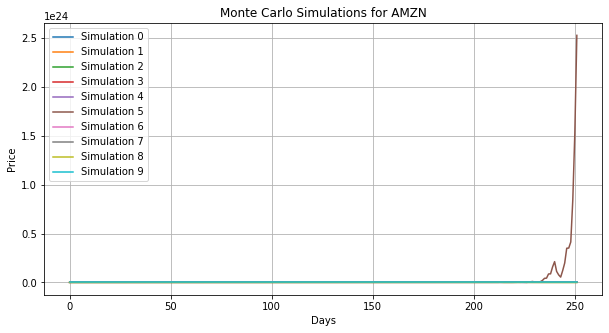

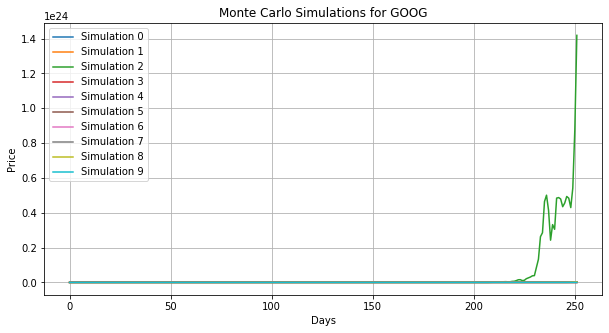

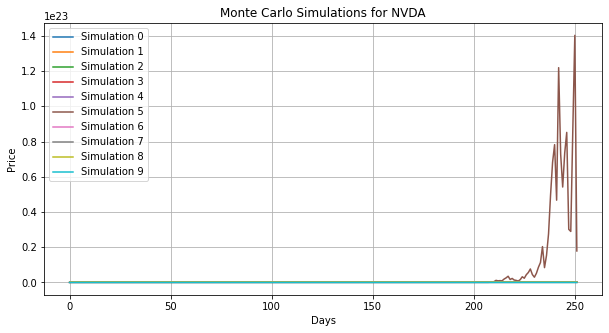

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Define the function to create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Define the function to train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
    
    return model

# Define the function to perform Monte Carlo simulations
def monte_carlo_simulations(last_price, days, mu, sigma, simulations):
    results = np.zeros((days, simulations))
    for sim in range(simulations):
        prices = [last_price]
        for _ in range(days):
            prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal()))
        results[:, sim] = prices[1:]
    return results

# Function to calculate the annualized mean and standard deviation of log returns
def calculate_annualized_params(df):
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    mu = np.mean(log_returns) * 252
    sigma = np.std(log_returns) * np.sqrt(252)
    return mu, sigma

# Process the data, train models, and perform simulations for each stock
def analyze_stocks(stock_list, n_steps, days_to_simulate, simulations):
    models_scalers = {}
    simulation_results = {}

    for stock in stock_list:
        df = pd.read_csv(f'{stock}.csv')
        df.fillna(method='ffill', inplace=True)  # Fill missing values
        df['Daily Returns'] = df['Close'].pct_change()

        features = ['Open', 'High', 'Low', 'Close', 'Volume']
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[features])

        X, y = create_sequences(scaled_features, n_steps)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model = train_lstm_model(X_train, y_train, X_val, y_val)
        models_scalers[stock] = (model, scaler)

        predicted_price = df['Close'].iloc[-1]

        mu, sigma = calculate_annualized_params(df)

        simulated_prices = monte_carlo_simulations(predicted_price, days_to_simulate, mu, sigma, simulations)
        simulation_results[stock] = simulated_prices

    return simulation_results

# List of stock tickers
stock_list = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'NVDA']
n_steps = 50  # Number of days to look back
days_to_simulate = 252  # Number of days to simulate in the future
simulations = 100  # Number of simulation paths

# Run the analysis
simulation_results = analyze_stocks(stock_list, n_steps, days_to_simulate, simulations)

# Plot the results
for stock, simulations in simulation_results.items():
    plt.figure(figsize=(10, 5))
    for i in range(min(simulations.shape[1], 10)):  # Plot a maximum of 10 simulations for readability
        plt.plot(simulations[:, i], label=f'Simulation {i}')
    plt.title(f'Monte Carlo Simulations for {stock}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
## MONTE CARLO AND BETA GENERATION

Epoch 1/20
270/270 [==============================] - 11s 31ms/step - loss: 0.4309 - val_loss: 0.4188
Epoch 2/20
270/270 [==============================] - 8s 29ms/step - loss: 0.4196 - val_loss: 0.4168
Epoch 3/20
270/270 [==============================] - 7s 27ms/step - loss: 0.4190 - val_loss: 0.4186
Epoch 4/20
270/270 [==============================] - 7s 27ms/step - loss: 0.4170 - val_loss: 0.4189
Epoch 5/20
270/270 [==============================] - 8s 29ms/step - loss: 0.4178 - val_loss: 0.4157
Epoch 6/20
270/270 [==============================] - 8s 30ms/step - loss: 0.4163 - val_loss: 0.4151
Epoch 7/20
270/270 [==============================] - 9s 32ms/step - loss: 0.4164 - val_loss: 0.4149
Epoch 8/20
270/270 [==============================] - 8s 31ms/step - loss: 0.4158 - val_loss: 0.4150
Epoch 9/20
270/270 [==============================] - 8s 30ms/step - loss: 0.4162 - val_loss: 0.4156
Epoch 10/20
270/270 [==============================] - 8s 30ms/step - loss: 0.4159 - val_l

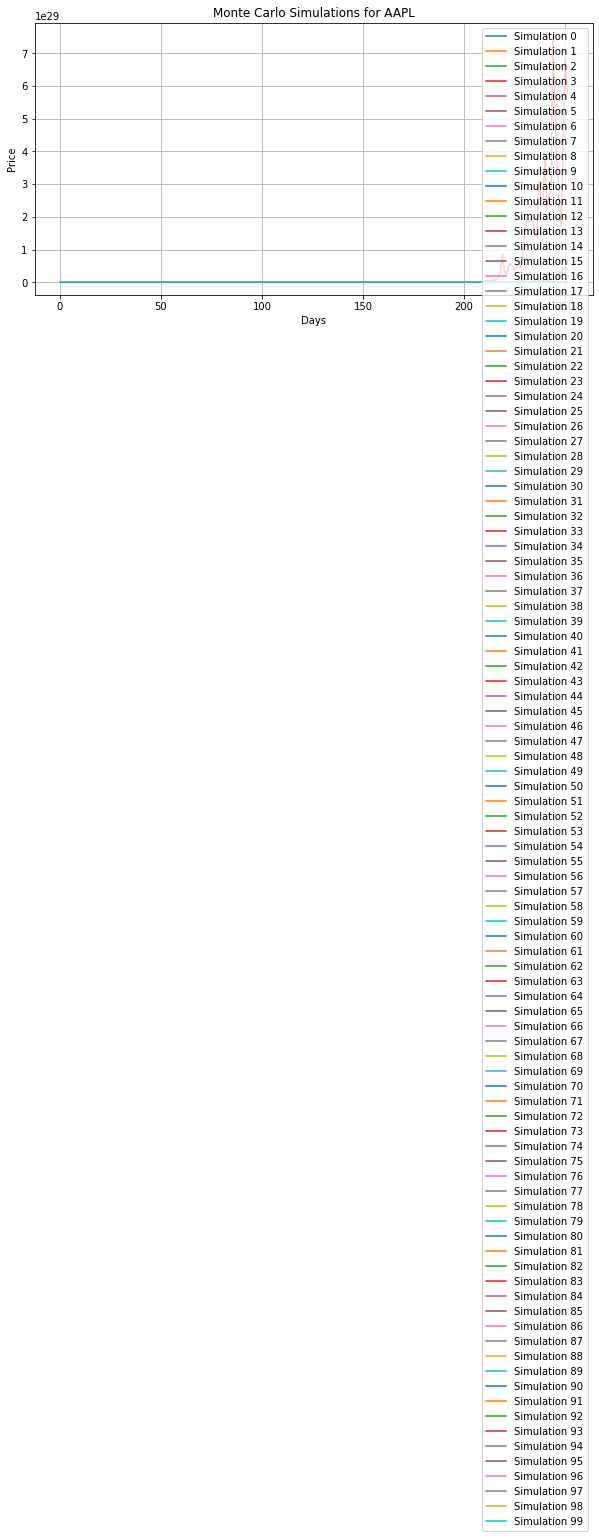

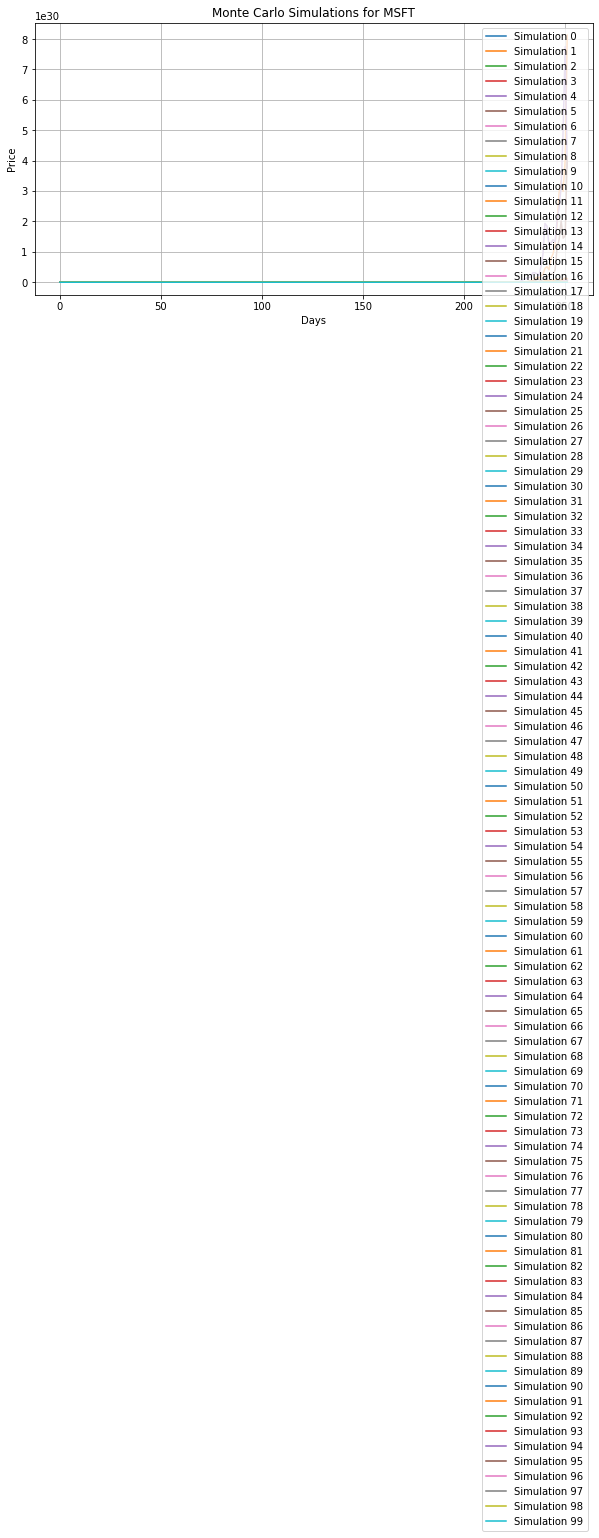

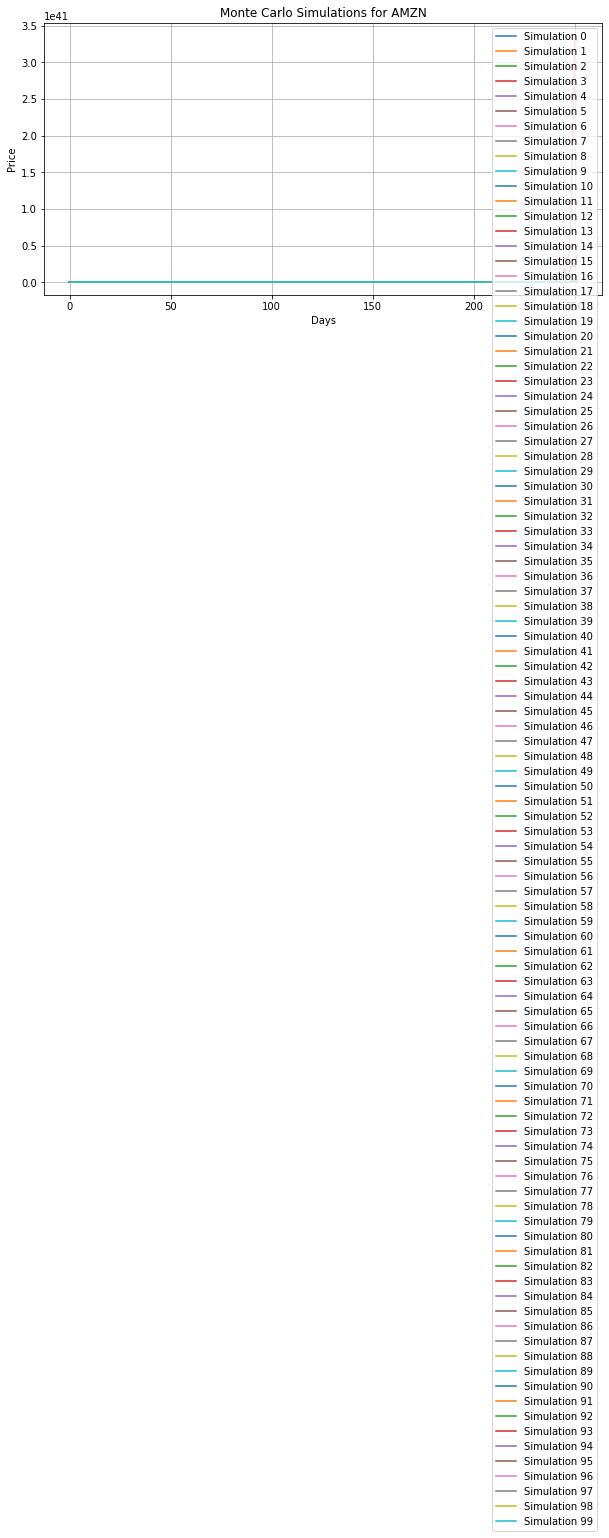

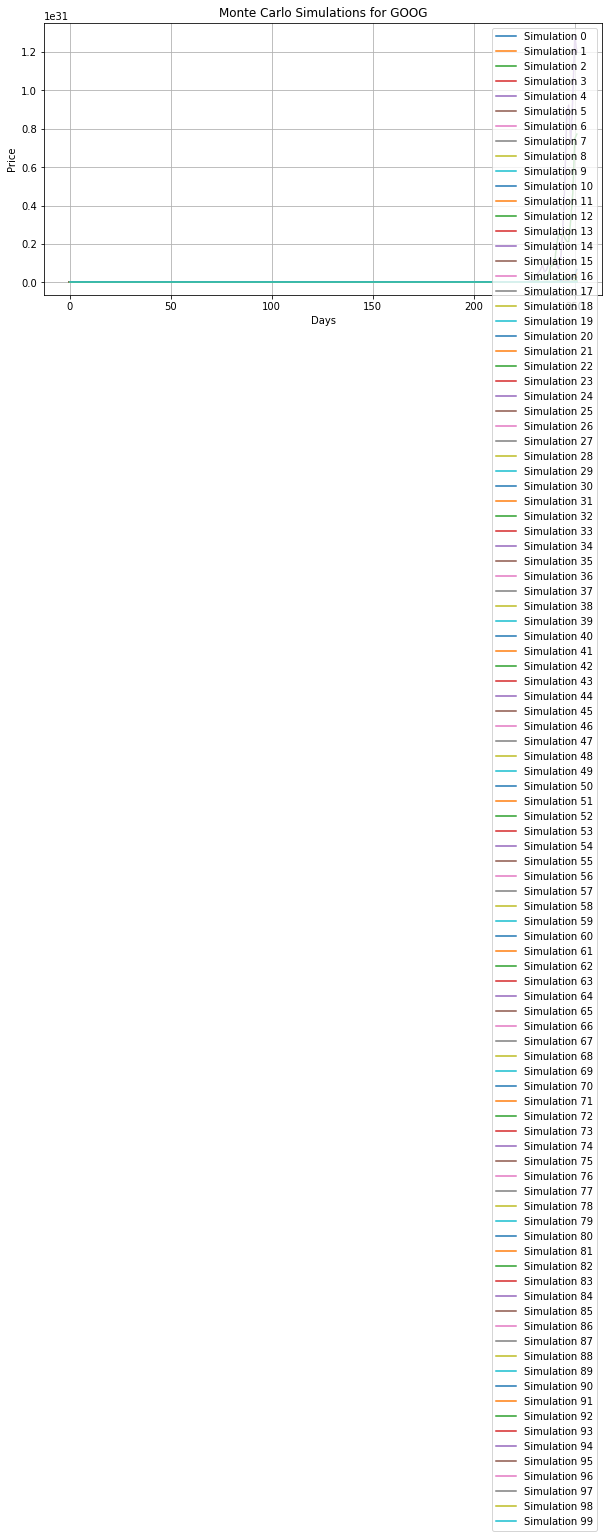

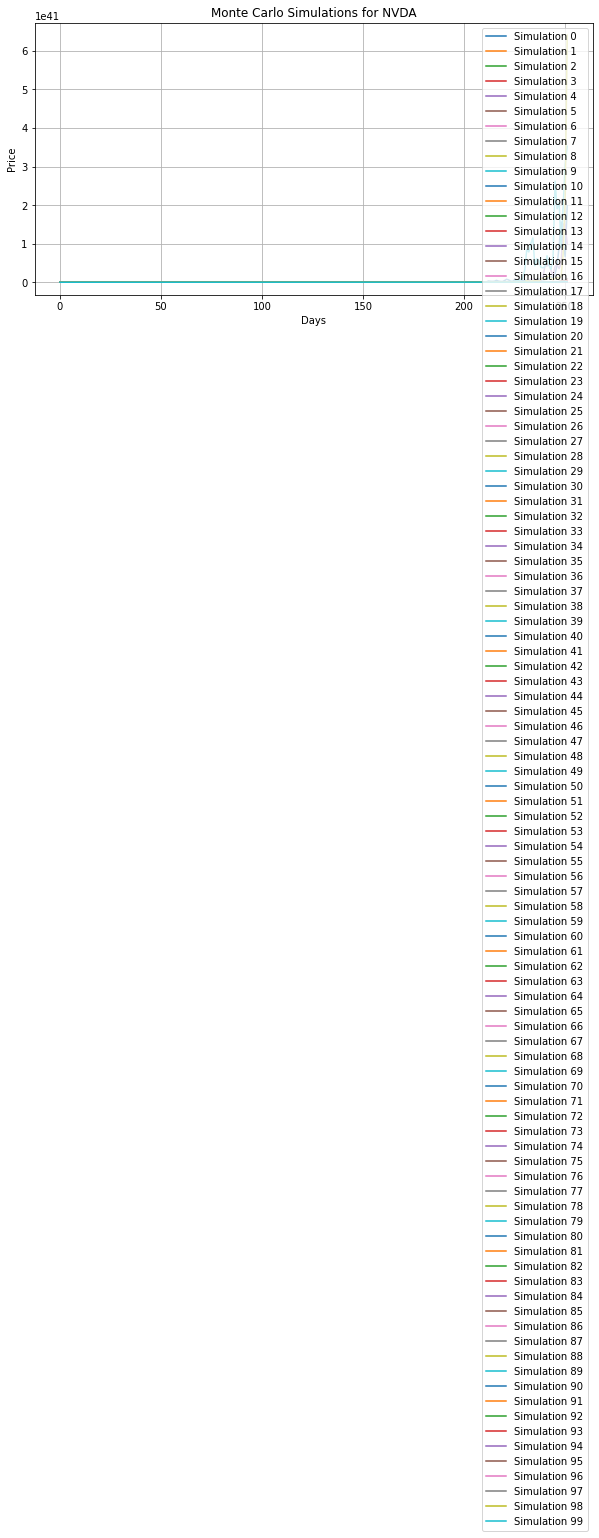

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the function to create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Define the function to train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
    
    return model

# Define the function to perform Monte Carlo simulations
def monte_carlo_simulations(last_price, days, mu, sigma, simulations):
    results = np.zeros((days, simulations))
    for sim in range(simulations):
        prices = [last_price]
        for _ in range(days):
            prices.append(prices[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal()))
        results[:, sim] = prices[1:]
    return results

# Process the data, train models, and perform simulations for each stock
def analyze_stocks(stock_list, n_steps, days_to_simulate, simulations):
    models_scalers = {}
    simulation_results = {}

    for stock in stock_list:
        df = pd.read_csv(f'{stock}.csv')
        df.fillna(method='ffill', inplace=True)  # Fill missing values
        df['Daily Returns'] = df['Close'].pct_change()

        features = ['Open', 'High', 'Low', 'Close', 'Volume']  # Define the features to use
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(df[features])

        X, y = create_sequences(scaled_features, n_steps)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        model = train_lstm_model(X_train, y_train, X_val, y_val)
        models_scalers[stock] = (model, scaler)

        predicted_price = df['Close'].iloc[-1]  # Using the actual last price for simplicity

        mu = np.mean(df['Daily Returns']) * 252  # Annualize mean
        sigma = np.std(df['Daily Returns']) * np.sqrt(252)  # Annualize standard deviation

        simulated_prices = monte_carlo_simulations(predicted_price, days_to_simulate, mu, sigma, simulations)
        simulation_results[stock] = simulated_prices

    return simulation_results

# List of stock tickers
stock_list = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'NVDA']
n_steps = 50  # Number of days to look back
days_to_simulate = 252  # Number of days to simulate in the future
simulations = 100  # Number of simulation paths

# Run the analysis
simulation_results = analyze_stocks(stock_list, n_steps, days_to_simulate, simulations)

# Plot the results
for stock, simulations in simulation_results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(simulations)
    plt.title(f'Monte Carlo Simulations for {stock}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(['Simulation ' + str(i) for i in range(simulations.shape[1])], loc='upper right')
    plt.grid(True)
    plt.show()


In [ ]:
# Assuming 'simulations' is a 2D numpy array with rows as days and columns as individual simulation paths
# And we're looking at the final day's simulated prices

# Convert prices to returns
simulated_returns = simulations[-1, :] / simulations[0, :] - 1

# Sort the simulated returns from worst to best
sorted_returns = np.sort(simulated_returns)

# Define the confidence level for VaR and CVaR (e.g., 95%)
confidence_level = 0.05

# Calculate VaR
var_index = int(confidence_level * len(sorted_returns))
value_at_risk = sorted_returns[var_index]

# Calculate CVaR
cvar = sorted_returns[:var_index].mean()

# Print the results
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence: {value_at_risk*100}%")
print(f"Conditional Value at Risk (CVaR) at {confidence_level*100}% confidence: {cvar*100}%")


Value at Risk (VaR) at 5.0% confidence: 8.922584901327624e+25%
Conditional Value at Risk (CVaR) at 5.0% confidence: 2.417957382061024e+25%
